In [2]:
%matplotlib inline
import os
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
pd.options.display.max_columns = 858  # In order to view all the columns
pd.options.display.max_rows = 64

# Metadata for TCGA and GTEx

I was fortunate enough to have finally found comprehensive metadata for both GTEx and TCGA, which is great because it enriches our feature set for machine learning. This notebook walks through the process of feature extraction, data cleaning, and a surface look at some of the properties of these samples.

TSVs were obtained from [here](http://snaptron.cs.jhu.edu/data).

In [3]:
tcga = pd.read_csv('tcga-sample-metadata.tsv', sep='\t', low_memory=False)
gtex = pd.read_csv('gtex-sample-metadata.tsv', sep='\t')

How many different metadata labels are we working?

In [4]:
print 'tcga: {}'.format(len(tcga.columns))
print 'gtex: {}'.format(len(gtex.columns))

tcga: 858
gtex: 301


...that's quite a few. Most likely aren't relevant, so we'll filter the rows, which represent samples, by RNA-Seq and examine the remaining columns for pertinent information.

## TCGA
First locate what column the sample barcodes are in

In [5]:
tcga[tcga.apply(lambda r: r.str.contains('TCGA-DQ-5630', case=False).any(), axis=1)] 

,rail_id,project,sample,experiment,run,read_count_as_reported_by_sra,reads_downloaded,proportion_of_reads_reported_by_sra_downloaded,paired_end,sra_misreported_paired_end,mapped_read_count,auc,sharq_beta_tissue,sharq_beta_cell_type,biosample_submission_date,biosample_publication_date,biosample_update_date,avg_read_length,geo_accession,bigwig_file,title,characteristics,gdc_cases.case_id,gdc_file_id,gdc_updated_datetime,gdc_file_name,gdc_submitter_id,gdc_file_size,gdc_access,gdc_platform,gdc_state,gdc_type,gdc_file_state,gdc_experimental_strategy,gdc_data_type,gdc_md5sum,gdc_data_format,gdc_data_category,gdc_center.code,gdc_center.name,gdc_center.short_name,gdc_center.center_id,gdc_center.namespace,gdc_center.center_type,gdc_metadata_files.updated_datetime.analysis,gdc_metadata_files.created_datetime.analysis,gdc_metadata_files.file_name.analysis,gdc_metadata_files.md5sum.analysis,gdc_metadata_files.data_format.analysis,gdc_metadata_files.access.analysis,gdc_metadata_files.file_id.analysis,gdc_metadata_files.data_category.analysis,gdc_metadata_files.file_size.analysis,gdc_metadata_files.file_state.analysis,gdc_metadata_files.updated_datetime.experiment,gdc_metadata_files.file_name.experiment,gdc_metadata_files.md5sum.experiment,gdc_metadata_files.file_id.experiment,gdc_metadata_files.file_size.experiment,gdc_metadata_files.updated_datetime.run,gdc_metadata_files.file_name.run,gdc_metadata_files.md5sum.run,gdc_metadata_files.file_id.run,gdc_metadata_files.file_size.run,gdc_cases.updated_datetime,gdc_cases.submitter_id,gdc_cases.demographic.updated_datetime,gdc_cases.demographic.gender,gdc_cases.demographic.submitter_id,gdc_cases.demographic.year_of_birth,gdc_cases.demographic.race,gdc_cases.demographic.demographic_id,gdc_cases.demographic.ethnicity,gdc_cases.demographic.year_of_death,gdc_cases.project.name,gdc_cases.project.released,gdc_cases.project.state,gdc_cases.project.primary_site,gdc_cases.project.project_id,gdc_cases.project.program.dbgap_accession_number,gdc_cases.project.program.name,gdc_cases.project.program.program_id,gdc_cases.tissue_source_site.project,gdc_cases.tissue_source_site.bcr_id,gdc_cases.tissue_source_site.code,gdc_cases.tissue_source_site.tissue_source_site_id,gdc_cases.tissue_source_site.name,gdc_cases.diagnoses.classification_of_tumor,gdc_cases.diagnoses.primary_diagnosis,gdc_cases.diagnoses.submitter_id,gdc_cases.diagnoses.tumor_stage,gdc_cases.diagnoses.age_at_diagnosis,gdc_cases.diagnoses.vital_status,gdc_cases.diagnoses.morphology,gdc_cases.diagnoses.days_to_death,gdc_cases.diagnoses.days_to_last_follow_up,gdc_cases.diagnoses.diagnosis_id,gdc_cases.diagnoses.tissue_or_organ_of_origin,gdc_cases.diagnoses.days_to_birth,gdc_cases.diagnoses.treatments.submitter_id,gdc_cases.diagnoses.treatments.treatment_id,gdc_cases.samples.sample_type_id,gdc_cases.samples.oct_embedded,gdc_cases.samples.submitter_id,gdc_cases.samples.intermediate_dimension,gdc_cases.samples.sample_id,gdc_cases.samples.is_ffpe,gdc_cases.samples.pathology_report_uuid,gdc_cases.samples.sample_type,gdc_cases.samples.shortest_dimension,gdc_cases.samples.days_to_collection,gdc_cases.samples.initial_weight,gdc_cases.samples.longest_dimension,gdc_cases.samples.portions.creation_datetime,gdc_cases.samples.portions.portion_number,gdc_cases.samples.portions.weight,gdc_cases.samples.portions.submitter_id,gdc_cases.samples.portions.portion_id,gdc_cases.samples.portions.analytes.analyte_type,gdc_cases.samples.portions.analytes.submitter_id,gdc_cases.samples.portions.analytes.analyte_id,gdc_cases.samples.portions.analytes.a260_a280_ratio,gdc_cases.samples.portions.analytes.concentration,gdc_cases.samples.portions.analytes.spectrophotometer_method,gdc_cases.samples.portions.analytes.analyte_type_id,gdc_cases.samples.portions.analytes.aliquots.source_center,gdc_cases.samples.portions.analytes.aliquots.submitter_id,gdc_cases.samples.portions.analytes.aliquots.aliquot_id,gdc_cases.samples.portions.analytes.aliquots.concentration,gdc_cases.samples.portion

One of our samples is in row 2,470. Let's find the column(s) to filter by.

In [6]:
print [str(x) for x in tcga.iloc[2470]].index('RNA-Seq')

33


In [7]:
tcga.columns[126]  # "Barcode" in original metadata

'gdc_cases.samples.portions.analytes.aliquots.submitter_id'

In [8]:
tcga.columns[33]  # We want to filter samples by this column using the term: 'RNA-Seq'

'gdc_experimental_strategy'

Subset by experimental strategy

In [9]:
tcga = tcga[tcga['gdc_experimental_strategy'] == 'RNA-Seq']
tcga.shape

(11284, 858)

Now the fun part, sift through 858 columns using the famous GSD (Graduate Student Descent) algorithm

### List of columns to keep for TCGA metadata

Sample Information
- gdc_cases.samples.submitter_id	
- reads_downloaded
- paired_end
- mapped_read_count
- auc
- gdc_platform
- gdc_file_size
- gdc_experimental_strategy
- gdc_center.code
- gdc_center.name	
- gdc_center.short_name
- gdc_data_category
- gdc_cases.tissue_source_site.name
- gdc_cases.samples.portions.analytes.aliquots.concentration
- gdc_cases.samples.portions.analytes.a260_a280_ratio
- cgc_sample_country_of_sample_procurement

Patient Information
- gdc_cases.demographic.gender
- gdc_cases.demographic.year_of_birth
- gdc_cases.demographic.race
- gdc_cases.demographic.ethnicity
- gdc_cases.samples.initial_weight
- gdc_cases.diagnoses.days_to_death
- gdc_cases.diagnoses.age_at_diagnosis
- gdc_cases.exposures.cigarettes_per_day	
- gdc_cases.exposures.alcohol_history
- gdc_cases.exposures.weight
- gdc_cases.exposures.years_smoked
- gdc_cases.exposures.height
- cgc_case_year_of_diagnosis

Tumor Information
- gdc_cases.project.name
- gdc_cases.project.primary_site
- gdc_cases.diagnoses.tumor_stage
- gdc_cases.diagnoses.vital_status
- gdc_cases.samples.sample_type
- cgc_case_new_tumor_event_after_initial_treatment
- cgc_case_pathologic_stage

Select, subset, and rename dataframe

In [10]:
tcga = tcga[['gdc_cases.samples.submitter_id', 'reads_downloaded', 'paired_end', 'mapped_read_count', 'auc', 
            'gdc_platform', 'gdc_file_size', 'gdc_experimental_strategy', 
            'gdc_center.short_name', 'gdc_data_category', 'gdc_cases.tissue_source_site.name', 
            'gdc_cases.samples.portions.analytes.aliquots.concentration', 
            'gdc_cases.samples.portions.analytes.a260_a280_ratio', 'cgc_sample_country_of_sample_procurement', 
            'gdc_cases.demographic.gender', 'gdc_cases.demographic.year_of_birth', 'gdc_cases.demographic.race', 
            'gdc_cases.demographic.ethnicity', 'gdc_cases.samples.initial_weight', 'gdc_cases.diagnoses.days_to_death', 
            'gdc_cases.diagnoses.age_at_diagnosis', 'gdc_cases.exposures.cigarettes_per_day', 
            'gdc_cases.exposures.alcohol_history', 'gdc_cases.exposures.weight', 'gdc_cases.exposures.years_smoked', 
            'gdc_cases.exposures.height', 'cgc_case_year_of_diagnosis', 'gdc_cases.project.name', 
            'gdc_cases.project.primary_site', 'gdc_cases.diagnoses.tumor_stage', 'gdc_cases.diagnoses.vital_status', 
            'gdc_cases.samples.sample_type', 'cgc_case_new_tumor_event_after_initial_treatment', 
            'cgc_case_pathologic_stage']]
tcga.index = tcga['gdc_cases.samples.submitter_id']
tcga.columns = ['submitter_id', 'reads_downloaded', 'paired_end', 'mapped_read_count', 'auc', 'platform', 
                'file_size', 'experimental_strategy', 'center_short', 'data_category', 
                'tissue_source_site', 'aliquots_concentration', 'a260_a280_ratio', 'country_of_sample_procurement', 
                'gender', 'year_of_birth', 'race', 'ethnicity', 'initial_weight', 'days_to_death', 
                'age_at_diagnosis', 'cigarettes_per_day', 'alcohol_history', 'weight', 'years_smoked', 
                'height', 'year_of_diagnosis', 'project_name', 'primary_site', 'tumor_stage', 'vital_status', 
                'sample_type', 'new_tumor_event_after_initial_treatment', 'pathologic_stage']
tcga.index = tcga['submitter_id']
tcga.index.name = None

Drop duplicate rows based on index

In [11]:
tcga = tcga[~tcga.index.duplicated(keep='first')]

In [12]:
tcga.shape

(11190, 34)

In [13]:
tcga.head()

,submitter_id,reads_downloaded,paired_end,mapped_read_count,auc,platform,file_size,experimental_strategy,center_short,data_category,tissue_source_site,aliquots_concentration,a260_a280_ratio,country_of_sample_procurement,gender,year_of_birth,race,ethnicity,initial_weight,days_to_death,age_at_diagnosis,cigarettes_per_day,alcohol_history,weight,years_smoked,height,year_of_diagnosis,project_name,primary_site,tumor_stage,vital_status,sample_type,new_tumor_event_after_initial_treatment,pathologic_stage
TCGA-CD-8534-01A,TCGA-CD-8534-01A,240016440,True,207116695,15223006507,Illumina HiSeq,1.570993e+10,RNA-Seq,BCGSC,Raw sequencing data,ILSBio,0.15,NaN,Vietnam,male,1970.0,asian,not hispanic or latino,NaN,NaN,15227.0,NaN,NaN,NaN,NaN,NaN,2011.0,Stomach Adenocarcinoma,Stomach,stage ii,alive,Primary Tumor,NO,Stage II
TCGA-ER-A19A-06A,TCGA-ER-A19A-06A,179705496,True,178311442,8517492780,Illumina HiSeq,7.741969e+09,RNA-Seq,UNC,Raw sequencing data,University of Pittsburgh,0.17,1.70,United States,male,1927.0,white,not hispanic or latino,110.0,NaN,29167.0,NaN,NaN,NaN,NaN,NaN,2006.0,Skin Cutaneous Melanoma,Skin,stage iv,alive,Metastatic,YES,Stage IV
TCGA-C5-A1M8-01A,TCGA-C5-A1M8-01A,195313702,True,192995706,9208332758,Illumina HiSeq,8.827799e+09,RNA-Seq,UNC,Raw sequencing data,Medical College of Wisconsin,0.15,1.75,United States,female,1958.0,white,not hispanic or latino,100.0,NaN,15848.0,NaN,NaN,75.0,NaN,163.0,2001.0,Cervical Squamous Cell Carcinoma and Endocervi...,Cervix,not reported,alive,Primary Tumor,NaN,NaN
TCGA-D1-A0ZN-01A,TCGA-D1-A0ZN-01A,30911468,True,30530086,2298775823,Illumina GA,1.980913e+09,RNA-Seq,UNC,Raw sequencing data,Mayo Clinic,0.14,1.87,None,female,1949.0,white,not hispanic or latino,120.0,NaN,22026.0,NaN,NaN,82.0,NaN,168.0,2009.0,Uterine Corpus Endometrial Carcinoma,Uterus,not reported,alive,Primary Tumor,NaN,NaN
TCGA-EM-A4FF-01A,TCGA-EM-A4FF-01A,206307190,True,201238067,9603544327,Illumina HiSeq,9.012918e+09,RNA-Seq,UNC,Raw sequencing data,University Health Network,0.16,1.78,Canada,female,1966.0,not reported,not reported,50.0,NaN,14796.0,NaN,NaN,NaN,NaN,NaN,2006.0,Thyroid Carcinoma,Thyroid,stage i,alive,Primary Tumor,YES,Stage I


#### Data Cleanup

Look for features with values that need NAN replacements, sparse / uninformative, etc

In [14]:
for c in tcga.columns:
    print c, len(tcga[c].unique())
    if len(tcga[c].unique()) == 1:
        print '\tdropping: ' + c + '\t' + str(tcga[c][0])
        tcga.drop(c, axis=1, inplace=True)

submitter_id 11190
reads_downloaded 11189
paired_end 1
	dropping: paired_end	True
mapped_read_count 11190
auc 11190
platform 2
file_size 11190
experimental_strategy 1
	dropping: experimental_strategy	RNA-Seq
center_short 3
data_category 1
	dropping: data_category	Raw sequencing data
tissue_source_site 217
aliquots_concentration 19
a260_a280_ratio 108
country_of_sample_procurement 33
gender 3
year_of_birth 91
race 7
ethnicity 4
initial_weight 221
days_to_death 1579
age_at_diagnosis 7797
cigarettes_per_day 186
alcohol_history 3
weight 379
years_smoked 64
height 135
year_of_diagnosis 34
project_name 33
primary_site 26
tumor_stage 21
vital_status 4
sample_type 7
new_tumor_event_after_initial_treatment 3
pathologic_stage 21


convert string nones to nans

In [15]:
tcga.replace('not reported', np.nan, inplace=True)
tcga.replace('None', np.nan, inplace=True)

#### Continuous Data

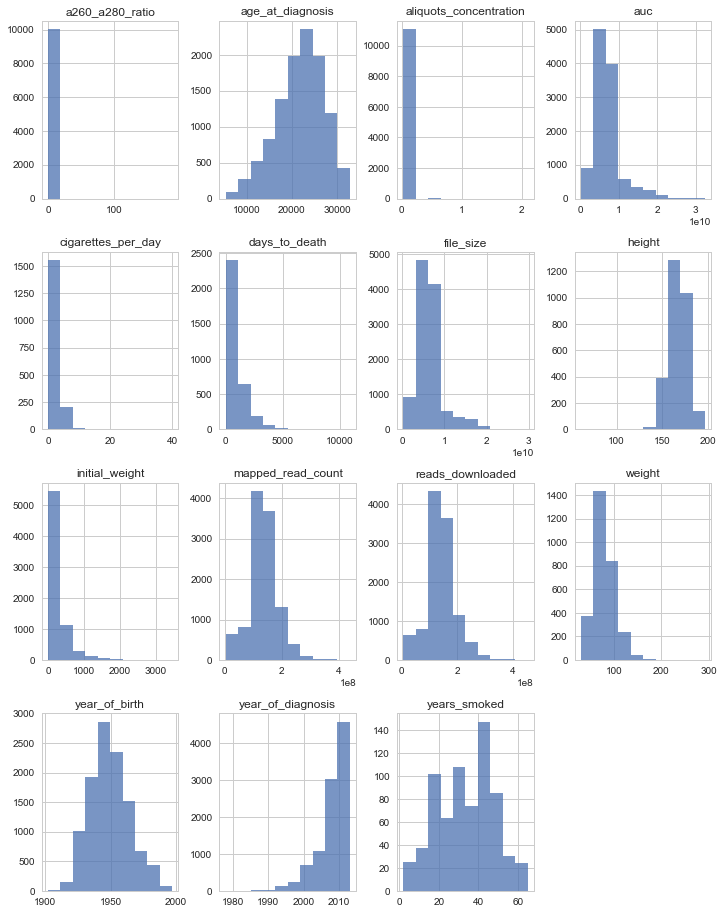

In [16]:
g = tcga.columns.to_series().groupby(tcga.dtypes).groups
g = {k.name: v for k, v in g.items()}

plt.rcParams['figure.figsize'] = [12, 16]
tcga[g['float64'] + g['int64']].hist(alpha=0.75);

#### Categorical Data

I don't have time to make these plots pretty ¯\\_(ツ)_/¯

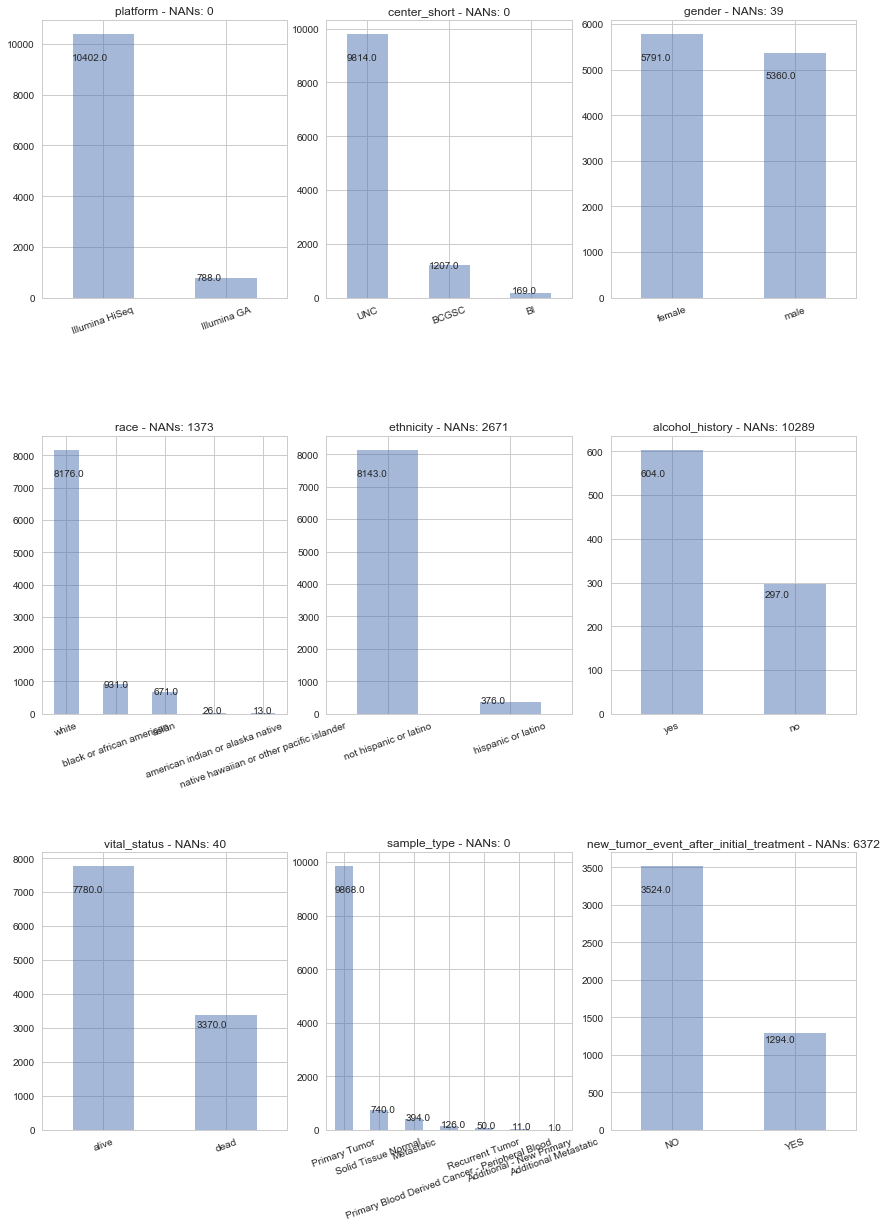

In [17]:
f, ax = plt.subplots(3, 3)
ax = ax.flatten()
f.tight_layout()
f.subplots_adjust(hspace=.5)
i = 0
for s in tcga[g['object']]:
    if len(tcga[s].unique()) < 10:
        tcga[s].value_counts().plot(kind='bar', ax=ax[i], alpha=0.50, rot=20)
        n = sum(tcga[s].value_counts())
        ax[i].set_title(s + ' - NANs: {}'.format(11190 - n))
        for p in ax[i].patches:
            ax[i].annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 0.9))
        i += 1

Save cleaned up metadata subset. We won't normalize / scale any of the values until later. 

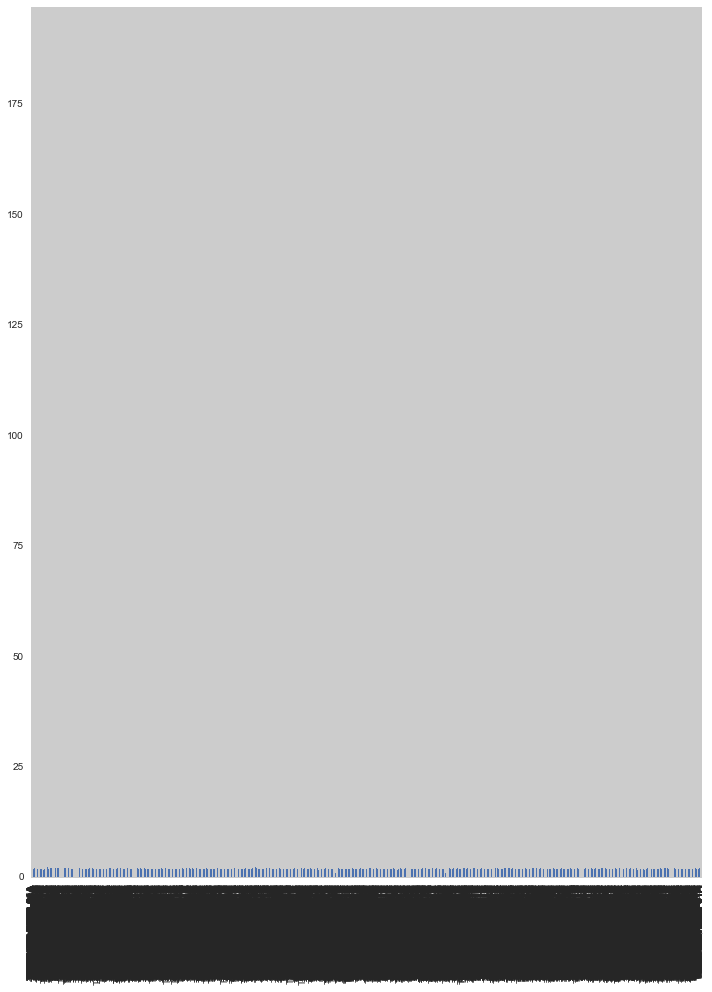

In [92]:
tcga.a260_a280_ratio.plot(kind='bar')

In [18]:
tcga.to_csv('tcga-metadata-cleaned.tsv', sep='\t')

## Combined Columns

Metadata that spans both datasets

- ID
    - submitter_id
    - SAMPID
- Reads
    - reads_downloaded
    - spots (??)
- size
    - file_size (bytes?, divide by a million)
    - size_MB
- platform
    - platform
    - Model
- sex
    - gender
    - Sex
- tissue
    - primary_site
    - Body_Site
- Sequencing
    - center_short
    - CenterName 
- weight
    - weight
    - WGHT
- height
    - height
    - HGHT
- mapped
    - mapped_read_count
    - SMMPPD
- race
    - race
    - RACE (3=white, 2=african american, 1=asian, 98,98,4=other)
- age
    - year_of_birth (2010 - year_of_birth = age)
    - AGE
- ethnicity
    - ethnicity
    - ETHNICITY (don't know code) 
- qc (Need transformation factor)
    - a260_a280_ratio
    - SMRIN

In [105]:
colnames = ['id', 'reads', 'size_MB', 'platform', 'sex', 'tissue', 'seq_site', 'weight', 'height', 
           'mapped_reads', 'race', 'age', 'qc']

tcga_sub = tcga[['submitter_id', 'reads_downloaded', 'file_size', 'platform', 'gender', 'primary_site',
                'center_short', 'weight', 'height', 'mapped_read_count', 'race', 'year_of_birth', 'a260_a280_ratio']]
tcga_sub.columns = colnames

gtex_sub = gtex[['SAMPID', 'spots', 'size_MB', 'Model', 'Sex', 'Body_Site', 'CenterName', 'WGHT', 'HGHT', 
                'SMMPPD', 'RACE', 'AGE', 'SMRIN']]
gtex_sub.columns = colnames

# TCGA A280 conversion to RIN 
# We'll model this as a piecewise linear transformation. 
# For values <=2.0    y = 20x - 30
# For values >2.0     y = -20x + 50
vals = []
for v in tcga_sub.qc:
    if v <= 2.0:
        vals.append(20*v - 30)
    else:
        vals.append(-20*v + 50)
tcga_sub.qc = vals

# Convert size to MB for TCGA
tcga_sub.size_MB = tcga_sub.size_MB.apply(lambda x: (x*1.0) / 1024 / 1024)

# Convert year of birth to age
tcga_sub.age = tcga_sub.age.apply(lambda x: 2010 - x)

# Create combined manifest
df = pd.concat([tcga_sub, gtex_sub], axis=0)

# Clean values for certain columns
df.platform.replace('Illumina HiSeq 2000', 'Illumina HiSeq', inplace=True)

df.tissue = df.tissue.apply(lambda x: x.split()[0])

df.race.replace(3, 'white', inplace=True)
df.race.replace(2, 'black or african american', inplace=True)
df.race.replace(1, 'asian', inplace=True)
df.race.replace(98, 'other', inplace=True)
df.race.replace(99, 'other', inplace=True)
df.race.replace(4, 'other', inplace=True)

df.index = range(df.shape[0])

In [109]:
df.to_csv('combined_manifest.tsv', sep='\t')

## GTEx

- Good news: Tons and tons of metadata for GTEx!
- Bad news: Too many possibly useful columns to hand select and ~200 of the columns have no corresponding descriptor so I have absolutely no idea what they are. 

Instead, let's select features by ranking learned weights (see notebook in same dir) and then worry about deriving what the column represents.